In [1]:
#%matplotlib inline
%matplotlib widget

In [2]:
isdark = True

In [3]:
# initialization
from rayoptics.environment import *

from rayoptics.gui import dashboards

from matplotlib import gridspec
from matplotlib.colors import LogNorm, PowerNorm, Normalize
from mpl_toolkits.mplot3d import axes3d

#import colorcet as cc

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [4]:
root_pth = Path(rayoptics.__file__).resolve().parent

# Create a new model

In [5]:
opm = OpticalModel()
sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ss = opm['specsheet']
ar = opm['analysis_results']
print(f"ray-optics version: {opm.ro_version}")

ray-optics version: 0.9.5


## Define first order aperture and field for system

In [6]:
pupil_diameter = 100.
pupil_radius = pupil_diameter/2
osp.pupil = PupilSpec(osp, key=['object', 'epd'], value=pupil_diameter)

# single field on-axis
osp.field_of_view = FieldSpec(osp, key=['object', 'angle'], flds=[0.0])

# wavelength for analysis: 550nm
osp.spectral_region = WvlSpec([('e', 1.0)], ref_wl=0)

### object at infinity, i.e. collimated input

In [7]:
sm.gaps[0].thi = 1e+11

In [8]:
opm.add_mirror(lbl='M1', profile=Conic, r=-500., cc=-1., t=-250.)

In [9]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
   M1:    -0.002000     -250.000       air    reflect -1      50.000
  Img:    -0.000000      0.00000                      -1  1.2880e-07


In [10]:
opm.update_model()
sm.list_model()
fod = ar['parax_data'].fod

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
   M1:    -0.002000     -250.000       air    reflect -1      50.000
  Img:    -0.000000      0.00000                      -1  1.2880e-07


In [11]:
listobj(sm)
listobj(osp)

0: Obj: dummy
profile: Spherical
c=0.0,   r=0.0
surface_od=0.0
t=100000000000.0 (+1);    medium: air

1: M1: reflect
profile: Conic
c=-0.002,   r=-500.0   conic cnst=-1.0
surface_od=49.99999999875
t=-250.0 (-1);    medium: air

2: Img: dummy
profile: Spherical
c=-0.0,   r=0.0
surface_od=1.2880050063122052e-07

do apertures: True
aperture: object epd; value=100.0
field: object angle; value=0.0
is_relative=False, is_wide_angle=False
x,y=0.0 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000
central wavelength=  546.0740 nm
wavelength (weight) =  546.0740 (1.000)*
focus shift=0.0



# Draw a lens picture

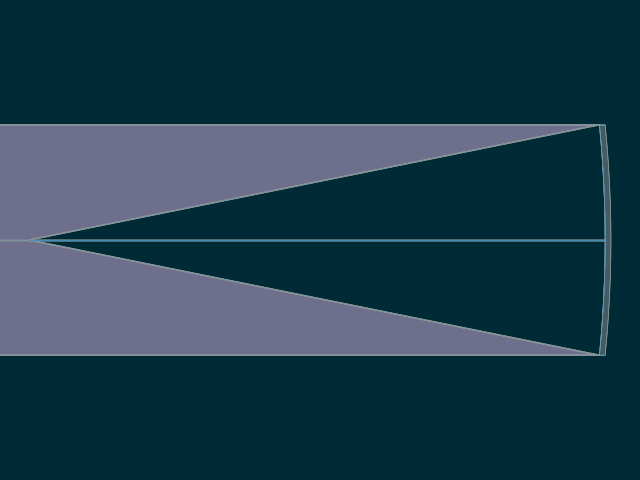

In [12]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark,
                        do_draw_ray_fans=False, do_paraxial_layout=False).plot()

# List first order data

In [13]:
pm.first_order_data()

efl                -250
f                   250
f'                 -250
ffl                -250
pp1                   0
bfl                -250
ppk                  -0
pp sep                0
f/#                 2.5
m              -2.5e-09
red              -4e+08
obj_dist          1e+11
obj_ang               1
enp_dist             -0
enp_radius           50
na obj            5e-10
n obj                 1
img_dist           -250
img_ht            4.364
exp_dist      -6.25e-07
exp_radius           50
na img              0.2
n img                -1
optical invariant       0.8728


# create focus dashboard

In [14]:
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)

### create fan and grid objects for use by plot grid

In [15]:
ray_xfan = analyses.RayFan(opm, f=fld, wl=wvl, xyfan='x')
ray_yfan = analyses.RayFan(opm, f=fld, wl=wvl, xyfan='y')
ray_grid = analyses.RayGrid(opm, f=fld, wl=wvl)

In [16]:
ndim = 32
maxdim = 256
pupil_grid = analyses.RayGrid(opm, num_rays=ndim, f=fld, wl=wvl, foc=-0.0)

### create lists of fans, data types, and plotting keyword arguments to drive 

In [17]:
xyabr_fan_list = [(ray_xfan, 'dx', dict(num_points=100)),
                  (ray_yfan, 'dy', dict(num_points=100, linestyle='--'))]

In [18]:
opd_fan_list = [(ray_yfan, 'opd', dict(linestyle='', linewidth=1, marker='D', markersize=3.5)),
                (ray_yfan, 'opd', dict(num_points=100, linewidth=2))]

In [19]:
one_wave = opm.nm_to_sys_units(wvl)
# one wave of defocus
dfoc = one_wave/(fod.img_na**2/(2*fod.n_img))
qwrt_dfoc = abs(0.25*dfoc)

# one wave of tilt
_, _, ref_sphere_radius, _ = fld.ref_sphere
shft = ref_sphere_radius*one_wave/fod.exp_radius

In [20]:
opd_scale = 1.0
ta_scale = .01

## create interactive defocus panel

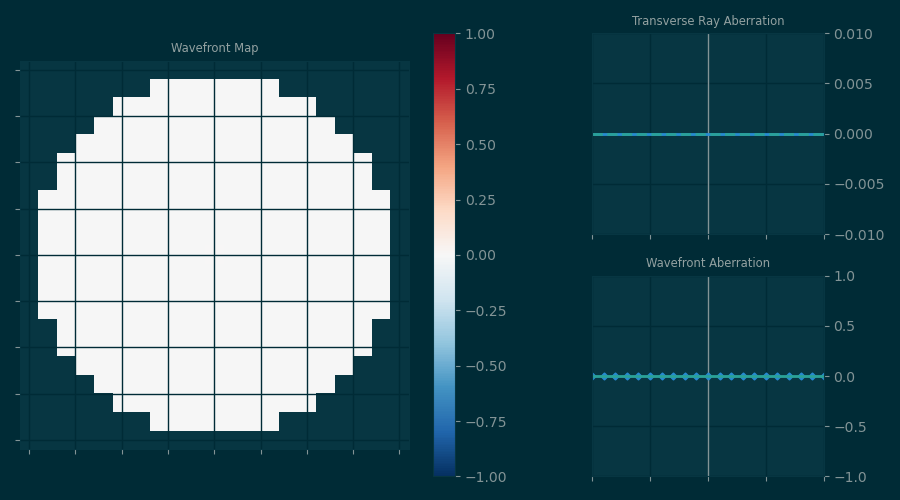

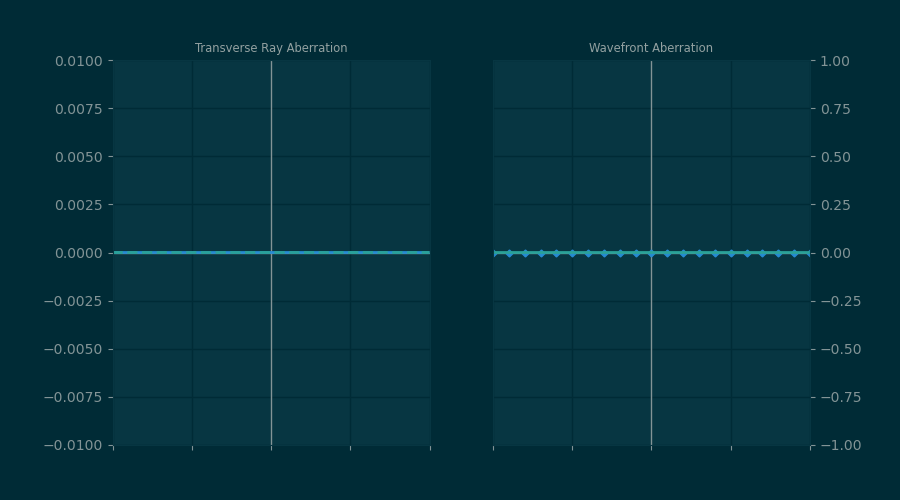

In [21]:
# create a figure with a wavefront map and transverse ray and opd ray fans
wfr = Wavefront(ray_grid, user_scale_value=opd_scale, do_contours=False, title='Wavefront Map')
xy_fan = RayFanPlot(xyabr_fan_list, user_scale_value=ta_scale, scale_type='user',
                    yaxis_ticks_position='right', title='Transverse Ray Aberration')
opd_fan = RayFanPlot(opd_fan_list, user_scale_value=opd_scale, scale_type='user',
                     yaxis_ticks_position='right', title='Wavefront Aberration')

fig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid, ray_xfan, ray_yfan], subplots=[wfr, xy_fan, opd_fan],
                 grid=(8, 13), figsize=[9, 5], tight_layout=True, is_dark=isdark)
fig.gridspecs = [fig.gs[:8, :8], fig.gs[:4, 9:], fig.gs[4:8, 9:]]

fig.refresh()

# create a figure with transverse ray and opd ray fans 
tabr = RayFanPlot(xyabr_fan_list, user_scale_value=ta_scale, scale_type='user',
                title='Transverse Ray Aberration')
wabr = RayFanPlot(opd_fan_list, user_scale_value=opd_scale, scale_type='user',
                  yaxis_ticks_position='right', title='Wavefront Aberration')
fig2 = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_xfan, ray_yfan], subplots=[tabr, wabr],
                 grid=(1, 2), figsize=[9, 5], is_dark=isdark)

fig2.plot()

image_defocus = ray_grid.foc
image_delta = ray_grid.image_delta
# create sliders for controlling defocus and image offset
defocus, x_shift, y_shift = dashboards.create_focus_dashboard([fig, fig2],
                                                   [ray_grid, ray_xfan, ray_yfan],
                                                   image_defocus, abs(dfoc), shft, image_delta)
display(widgets.HBox([defocus, y_shift]))

## create wavefront and diffraction PSF display

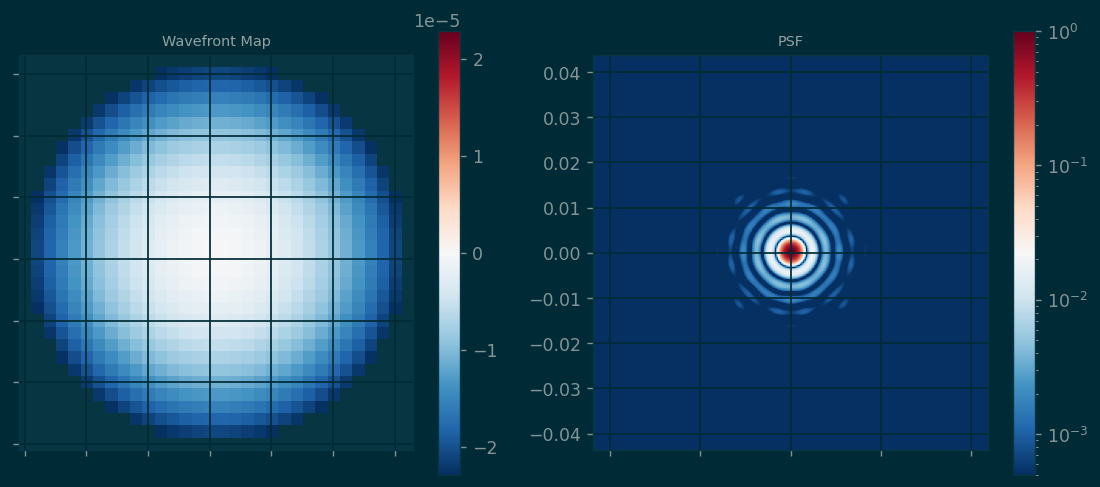

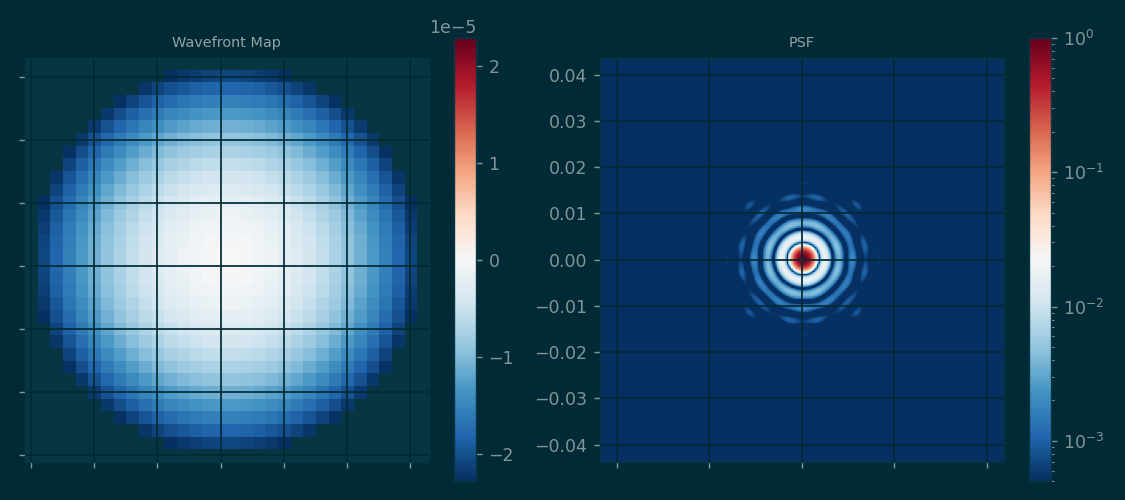

In [22]:
wfr = Wavefront(pupil_grid, user_scale_value=None, do_contours=False,
                title='Wavefront Map') #, cmap="BrBG_r")

psf = DiffractionPSF(pupil_grid, maxdim, # cmap="BrBG_r",   # cmap=cc.m_fire,
                     yaxis_ticks_position='left', title='PSF', norm=LogNorm(vmin=5e-4)) #norm=PowerNorm(gamma=0.5, vmin=2e-3))

fig_psf = plt.figure(FigureClass=AnalysisFigure, data_objs=[pupil_grid], subplots=[wfr, psf],
                     grid=(1, 2), figsize=[9, 4], dpi=125, tight_layout=True, is_dark=isdark)

fig_psf.plot()

## step by step PSF calculation

In [23]:
from numpy.fft import fftshift, fft2

In [24]:
ndim = 64
maxdim = 4096
pupil_grid = analyses.RayGrid(opm, num_rays=ndim, f=fld, wl=wvl, foc=-0.0)

In [25]:
psf_dim = analyses.psf_sampling(maxdim, ndim)
n_airy = psf_dim[2]
psf_dim

(4096, 64, 156)

In [26]:
opd = pupil_grid.grid[2]

In [27]:
AP = analyses.calc_psf(opd, ndim, maxdim)

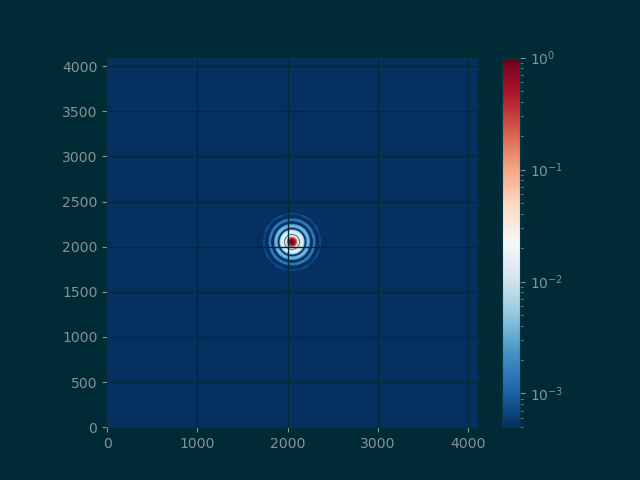

In [28]:
figg = plt.figure()
plt.imshow(AP, origin='lower', cmap="RdBu_r", norm=LogNorm(vmin=5e-4))
plt.colorbar()
plt.show()

In [29]:
delta_x, delta_xp = analyses.calc_psf_scaling(pupil_grid, ndim, maxdim)

In [30]:
maxdim_by_2 = maxdim//2
W = np.zeros([maxdim, maxdim])
nd2 = ndim//2

In [31]:
image_scale = maxdim_by_2 * delta_xp
xi = np.linspace(-image_scale, image_scale, maxdim)
yi = np.linspace(-image_scale, image_scale, maxdim)
#xi = np.linspace(-image_scale, image_scale, nd)
#yi = np.linspace(-image_scale, image_scale, nd)
[XI, YI] = np.meshgrid(xi, yi)

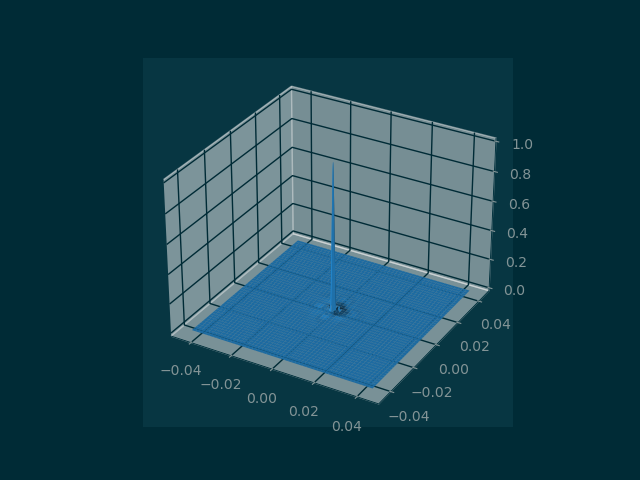

In [32]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(XI, YI, AP)

In [33]:
delta_x, delta_xp, image_scale

(1.5625, np.float64(2.133101567832754e-05), np.float64(0.0436859201092148))

In [34]:
maxdim/n_airy, maxdim/ndim

(26.256410256410255, 64.0)

In [35]:
psf_dim

(4096, 64, 156)